In [37]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('data/airline_delay_train_new.csv')

#Process pipeline 
- Separate target from features 
- Pipeline 
- CV split 
- Scores 

In [3]:
y = df['dep_delayed_15min']
X = df.drop(['dep_delayed_15min'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split( 
                        X,y,test_size = 0.20, random_state = 42) 

In [5]:
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

In [6]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [7]:
X_train

FlightDate DepTime UniqueCarrier Origin Dest  Distance Day_of_Week
236722    1/26/10   21:04            MQ    DFW  TXK       181     Tuesday
169709    1/16/10    1:08            9E    GRR  MEM       591    Saturday
334927    1/31/10   19:43            WN    BUR  OAK       325      Sunday
368647    1/26/10   18:35            AA    SAT  DFW       247     Tuesday
295143    1/14/10   16:05            EV    ATL  PNS       272    Thursday
...           ...     ...           ...    ...  ...       ...         ...
259178    1/17/10   17:29            WN    TPA  JAX       180      Sunday
365838    1/15/10   22:16            YV    CLT  IAD       321      Friday
131932    1/19/10   13:04            UA    BOS  SFO      2704     Tuesday
146867    1/28/10   21:00            YV    CLT  BHM       351    Thursday
121958    1/31/10   11:50            WN    HOU  AUS       148      Sunday

[324836 rows x 7 columns]

In [8]:
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state= 42))])

In [9]:
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(baseline_pipeline,X, y,cv=3, scoring ='roc_auc')
# the parameters frid expects the same name as the pipeline "classifier"

param_grid = {
    'classifier__max_depth': [80, 100],
    'classifier__max_features': [2, 3],
    'classifier__min_samples_leaf': [3, 4, 5],
    'classifier__min_samples_split': [8, 10, 12],
    'classifier__n_estimators': [100, 200, 300]
}

In [10]:
def model_fit():
    grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    print ("the best model params: ", grid_search.best_params_)
    best_grid = grid_search.best_estimator_
    return best_grid

In [11]:
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [40]:
grid_search.fit(X_train, y_train)

In [41]:
grid_search.best_params_

In [167]:
best_grid = grid_search.best_estimator_

In [8]:
def model_pedict():
    testscore = best_grid.predict_proba(X_test)
    return log_loss(y_test, testscore)

In [ ]:
testscore = best_grid.predict_proba(X_test)

In [172]:
log_loss(y_test, testscore)

0.4828014996428915

In [24]:

model = xgb.XGBClassifier(n_estimators = 700)
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

In [19]:
param_grid_xgboost = {
    'model__n_estimators': [500,700]
}

In [11]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgboost, cv=3, n_jobs=-1, scoring='roc_auc')

In [12]:
grid_xgb.fit(X_train, y_train)

/opt/anaconda3/envs/fsds/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:06:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(strategy='constant'),
                                                                         Index(['Distance'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(

In [34]:
best_xgb = grid_xgb.best_estimator_

In [35]:
best_xgb.named_steps["model"].get_booster().get_score(importance_type='weight')

{'f23': 141,
 'f30': 164,
 'f12': 145,
 'f29': 131,
 'f1517': 106,
 'f26': 107,
 'f0': 5570,
 'f1188': 147,
 'f1472': 124,
 'f985': 117,
 'f975': 91,
 'f1364': 43,
 'f987': 380,
 'f1426': 9,
 'f1142': 4,
 'f978': 147,
 'f1005': 220,
 'f980': 106,
 'f1289': 162,
 'f1266': 2,
 'f1308': 26,
 'f1425': 27,
 'f1121': 6,
 'f976': 69,
 'f1214': 5,
 'f973': 188,
 'f1233': 112,
 'f772': 6,
 'f14': 149,
 'f1558': 315,
 'f1071': 87,
 'f1024': 34,
 'f988': 115,
 'f972': 175,
 'f1197': 31,
 'f1241': 88,
 'f1088': 17,
 'f983': 65,
 'f982': 160,
 'f162': 12,
 'f1154': 28,
 'f5': 45,
 'f19': 35,
 'f10': 138,
 'f13': 98,
 'f18': 119,
 'f984': 260,
 'f1355': 71,
 'f1361': 5,
 'f1395': 30,
 'f1259': 4,
 'f1066': 125,
 'f1333': 30,
 'f1320': 2,
 'f450': 5,
 'f986': 186,
 'f974': 36,
 'f1563': 241,
 'f6': 47,
 'f8': 34,
 'f1117': 83,
 'f1401': 60,
 'f1467': 11,
 'f28': 86,
 'f20': 51,
 'f1065': 98,
 'f1185': 11,
 'f1328': 1,
 'f1232': 24,
 'f1419': 29,
 'f1414': 29,
 'f1130': 32,
 'f1176': 39,
 'f1156': 23,

In [38]:
feat_impact = permutation_importance(best_xgb, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

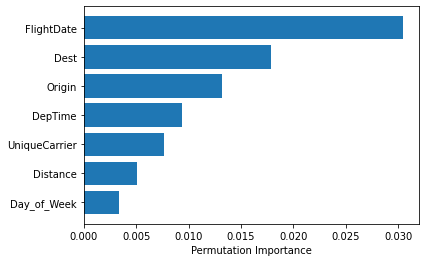

In [39]:
sorted_idx = feat_impact.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], feat_impact.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [17]:
best_xgb_score = best_xgb.predict_proba(X_test)

In [18]:
log_loss(y_test, best_xgb_score)

0.4529898514021672

In [19]:
test = pd.read_csv('data/airline_delay_test_new.csv')

In [20]:
ext_test = test.drop('dep_delayed_15min', axis=1)

In [21]:
best_xgb_score_test = best_xgb.predict_proba(ext_test)

In [22]:
log_loss(test['dep_delayed_15min'], best_xgb_score_test)

0.4513241335009996

## Python Serialization for persistence 

In [24]:
# import joblib
from joblib import dump

# dump the pipeline model
dump(grid_xgb.best_estimator_, filename="xgboost.joblib")

['xgboost.joblib']

In [26]:
X_train.columns

Index(['FlightDate', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance',
       'Day_of_Week'],
      dtype='object')